In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

c:\Users\darvarir\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Neural Network on PCA Results

In [9]:
# Directory where PCA results are saved
pca_dir = "../../data/pca_data/byBasin_pca"
result_dir="../../data/performance_comparison"

# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withPCA"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Get a list of all PCA result files
pca_files = [f for f in os.listdir(pca_dir) if f.endswith('_pca_with_target.csv')]

# Dictionary to store results for each basin
results = {}

# Process each PCA result file
for file in pca_files:
    basin_name = file.replace('_pca_with_target.csv', '')  
    pca_df = pd.read_csv(f"{pca_dir}/{file}")

    # Separate data with known and unknown 'Li' values
    known_data = pca_df.dropna(subset=['Li'])
    unknown_data = pca_df[pca_df['Li'].isnull()]

    # Prepare training and testing data from known data
    principal_components = [f'PC{i+1}' for i in range(10)]  # Use the first 10 principal components
    X_known = known_data[principal_components]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin_name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Explained Variance': explained_variance}
    print(f"Basin: {basin_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual Li concentrations')
    plt.ylabel('Predicted Li concentrations')
    plt.title(f'Actual vs. Predicted for {basin_name}')
    plot_path = os.path.join(plot_dir, f"{basin_name}_actual_vs_predicted.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[principal_components]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred


        # Save predicted data for unknown values
        predicted_data_path = os.path.join(predicted_data_dir, f"{basin_name}_predicted.csv")
        unknown_data.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(10, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin_name}')
        plot_hist_path = os.path.join(plot_dir, f"{basin_name}_neural_network_predicted_distribution.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_with_pca = pd.DataFrame(results).T
nn_results_df_with_pca.to_csv(os.path.join(result_dir, "neural_network_performance_withPCA.csv"), index_label='Basin')

print("Saved performance metrics with PCA to CSV.")

c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Basin: Anadarko - MSE: 1853.936654623336, R2: 0.8137699528374271, MAE: 15.386557879009336, RMSE: 43.057364696685, Explained Variance: 0.8163329281534587
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Basin: Appalachian - MSE: 1470.1071285725013, R2: 0.5976307733525963, MAE: 26.61525398693922, RMSE: 38.34197606504523, Explained Variance: 0.6191525050028256
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Basin: Fort Worth - MSE: 155.19272446659457, R2: 0.87336736910755, MAE: 6.529839556217194, RMSE: 12.457637194371754, Explained Variance: 0.9036525877961074
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Basin: Great Plains - MSE: 38280.95531645347, R2: -0.026100318956620905, MAE: 56.02993759888869, RMSE: 195.65519496413447, Explained Variance: 0.05321945479616397
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Basin: Gulf Coast - MSE: 828.376849049731, R2: 0.8535486429338272, MAE: 15.436314866510237, RMSE: 28.7815365998713, Explained Variance: 0.857448019201755
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Illinois - MSE: 85.5829839884865, R2: 0.5523902136493563, MAE: 6.542815910339355, RMSE: 9.251107176359298, Explained Variance: 0.5593659381691001
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Basin: Michigan - MSE: 158.13943556320777, R2: 0.6043798421402918, MAE: 8.598033836205802, RMSE: 12.575350315725116, Explained Variance: 0.6045943667046568
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Basin: Oklahoma Platform - MSE: 193.49888147298464, R2: 0.38401155698950384, MAE: 9.437256911502164, RMSE: 13.910387538562132, Explained Variance: 0.39610044005943723
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Basin: Pacific - MSE: 3.8128646759886053, R2: 0.6317946174810463, MAE: 1.0331471902337566, RMSE: 1.9526558006951982, Explained Variance: 0.6431796139842888
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Basin: Permian - MSE: 4630.77160427882, R2: 0.08935794508827799, MAE: 15.005552246017553, RMSE: 68.0497729921182, Explained Variance: 0.10502796428793992
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Basin: Rocky Mountain - MSE: 36.43761061600596, R2: 0.8301408671392793, MAE: 3.433006858885717, RMSE: 6.036357396311617, Explained Variance: 0.8302087730136875
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Basin: Williston - MSE: 334.80202178361276, R2: 0.8547424887701214, MAE: 11.693047084015115, RMSE: 18.297596065702532, Explained Variance: 0.854794301011591
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\657789940.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Saved performance metrics with PCA to CSV.


### Neural Network on Imputed Data without PCA

In [8]:
# Load the dataset with all basins
df = pd.read_csv("../../data/df_output/df_cleaned_imputed.csv")


# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withoutPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withoutPCA"
result_dir="../../data/performance_comparison"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Define features to use for predicting 'Li'
predictors = ['B', 'Ba', 'Br', 'HCO3', 'FeTot', 'K', 'Na', 'Cl', 'SO4', 'Mg', 'Ca', 'Sr', 'Zn', 'TDS', 'DEPTHUPPER']

# Dictionary to store results for each basin
results = {}

# Loop through each unique basin category
for basin in df['BASIN_CATEGORY'].unique():
    print(f"Processing Gradient Boosting for {basin}")
    df_basin = df[df['BASIN_CATEGORY'] == basin]

    # Separate data with known and unknown 'Li' values
    known_data = df_basin.dropna(subset=['Li'])
    unknown_data = df_basin[df_basin['Li'].isnull()]

    # Prepare training and testing data from known data
    X_known = known_data[predictors]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Explained Variance': explained_variance
    }
    print(f"Basin: {basin} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual Li concentrations')
    plt.ylabel('Predicted Li concentrations')
    plt.title(f'Actual vs. Predicted for {basin}')
    plot_path = os.path.join(plot_dir, f"{basin}_actual_vs_predicted.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[predictors]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred


        # Save predicted data for unknown values
        predicted_data_path = os.path.join(predicted_data_dir, f"{basin}_predicted.csv")
        unknown_data.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(10, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin}')
        plot_hist_path = os.path.join(plot_dir, f"{basin}_neural_network_predicted_distribution.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_without_pca = pd.DataFrame(results).T
nn_results_df_without_pca.to_csv(os.path.join(result_dir, "neural_network_performance_withoutPCA.csv"), index_label='Basin')

print("Saved performance metrics without PCA to CSV.")

Processing Gradient Boosting for Appalachian


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Basin: Appalachian - MSE: 4137.22696918085, R2: -0.13236156991533332, MAE: 42.62718175630533, RMSE: 64.32127928750212, Explained Variance: -0.09865821440061717
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
Processing Gradient Boosting for Permian


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Basin: Permian - MSE: 11845.111958764233, R2: -1.3293433614436165, MAE: 85.35507727325577, RMSE: 108.8352514526623, Explained Variance: -1.0341224290333901
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Oklahoma Platform


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Basin: Oklahoma Platform - MSE: 1713608.2273666905, R2: -5454.136773247737, MAE: 341.8489790683634, RMSE: 1309.0485962586304, Explained Variance: -5401.946079223986
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Gulf Coast


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Basin: Gulf Coast - MSE: 5050.841477369781, R2: 0.10704579741036424, MAE: 46.15482796680501, RMSE: 71.0692723852565, Explained Variance: 0.298163348094059
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Williston


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Basin: Williston - MSE: 19202.165613157118, R2: -7.331069126559509, MAE: 107.91626651382438, RMSE: 138.57187886853927, Explained Variance: -2.580817906622487
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Michigan


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Michigan - MSE: 165880.66135841105, R2: -413.98651616381295, MAE: 257.5713350556691, RMSE: 407.2844968304232, Explained Variance: -412.61695902114013
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
Processing Gradient Boosting for Pacific


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Basin: Pacific - MSE: 4491.667659289143, R2: -432.75685978358456, MAE: 52.00393854207007, RMSE: 67.01990494837442, Explained Variance: -430.413678922574
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
Processing Gradient Boosting for Illinois


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Illinois - MSE: 51318.28689794045, R2: -267.4011045625425, MAE: 185.27147741699218, RMSE: 226.5353987745413, Explained Variance: -165.55032997893534
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
Processing Gradient Boosting for Great Plains


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Basin: Great Plains - MSE: 14399.139894778978, R2: 0.6140388368943521, MAE: 64.82203592887291, RMSE: 119.9964161747299, Explained Variance: 0.6446258816962396
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
Processing Gradient Boosting for Anadarko


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Basin: Anadarko - MSE: 9709.66293801563, R2: 0.024653306050138823, MAE: 71.90599939012866, RMSE: 98.53762194215786, Explained Variance: 0.30291820167082684
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
Processing Gradient Boosting for Rocky Mountain


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Basin: Rocky Mountain - MSE: 3388.5537951362758, R2: -14.796228116036737, MAE: 35.38206219851542, RMSE: 58.21128580555729, Explained Variance: -11.266101128472204
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
Processing Gradient Boosting for Fort Worth


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Fort Worth - MSE: 159316.47032454846, R2: -128.99748442485227, MAE: 311.4550798034668, RMSE: 399.14467342625085, Explained Variance: -126.06357078308312
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
Saved performance metrics without PCA to CSV.


C:\Users\darvarir\AppData\Local\Temp\ipykernel_27436\4288384262.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


## Performance Comparison

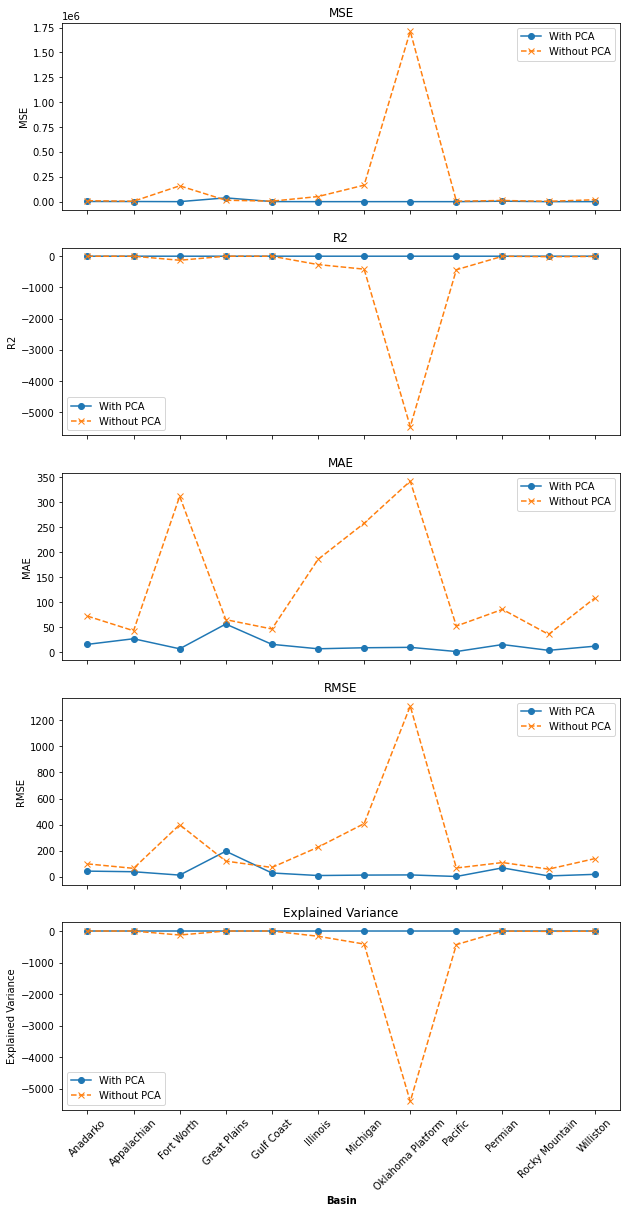

In [10]:
# Merge the two results DataFrames
nn_combined_results = nn_results_df_with_pca.join(nn_results_df_without_pca, lsuffix='_with_pca', rsuffix='_without_pca')

# Define the metrics to compare
metrics = ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance']

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 20), sharex=True)

# Plot comparisons for each metric
for idx, metric in enumerate(metrics):
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_with_pca'], marker='o', label='With PCA', linestyle='-')
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_without_pca'], marker='x', label='Without PCA', linestyle='--')
    
    axs[idx].set_ylabel(metric)
    axs[idx].set_title(metric)
    axs[idx].legend()

# Set common labels
plt.xlabel('Basin', fontweight='bold')
plt.xticks(rotation=45)
plt.savefig("../../images/performance_comparison_plots/neural_network_performance_comparison.png")